In [1]:
import os
import re
import torch
from transformers import T5EncoderModel, AutoTokenizer
from pathlib import Path
from f5_tts.infer.utils_infer import (
    infer_process,
    load_vocoder,
    preprocess_ref_audio_text,
    remove_silence_for_generated_wav,
)
from f5_tts.model.cfm import T5Conditioner
from f5_tts.model import DiT, CFM
from f5_tts.model.utils import get_tokenizer
from f5_tts.train.utils import make_html
import torchaudio
import argparse

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

cfg_strength = 3.0
scale_phi = 0.75
ckpt_path = './f5_tts/model_1200000_base.pt'

mel_spec_type = "vocos"
vocoder_name = "vocos"
target_sample_rate = 24000
n_mel_channels = 100
hop_length = 256
win_length = 1024
n_fft = 1024
target_rms = 0.1
cross_fade_duration = 0.15
ode_method = "euler"
nfe_step = 32  # 16, 32
sway_sampling_coef = -1.0
speed = 1.0
fix_duration = None
vocab_file = "./f5_tts/infer/examples/vocab.txt"
tokenizer = "custom"
ode_method = "euler"

# load model
model_cls = DiT
model_cfg = dict(
    dim=1024, 
    depth=22, 
    heads=16, 
    ff_mult=2, 
    text_dim=512, 
    conv_layers=4
)

vocab_char_map, vocab_size = get_tokenizer(vocab_file, tokenizer)
vocoder = load_vocoder(vocoder_name=vocoder_name, is_local=True, local_path="./f5_tts/vocoder")

transformer=model_cls(**model_cfg, text_num_embeds=vocab_size, mel_dim=n_mel_channels)
text_conditioner = T5Conditioner(t5_model_name="t5-base", max_length=32).to(device)
text_conditioner.eval()

mel_spec_kwargs=dict(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    n_mel_channels=n_mel_channels,
    target_sample_rate=target_sample_rate,
    mel_spec_type=mel_spec_type,
)

odeint_kwargs=dict(
    method=ode_method,
)

model = CFM(
    transformer=transformer,
    mel_spec_kwargs=mel_spec_kwargs,
    odeint_kwargs=odeint_kwargs,
    vocab_char_map=vocab_char_map,
).to(device)

dtype = torch.float32
checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint, strict=False)
del checkpoint
torch.cuda.empty_cache()

@torch.no_grad
def main(script, prefix_path=None, prefix_script=None):
    if prefix_path is not None and prefix_script is not None:
        main_voice = {"ref_audio": prefix_path, "ref_text": prefix_script}
        voices = {"main": main_voice}
        
        for voice in voices:
            voices[voice]["ref_audio"], voices[voice]["ref_text"] = preprocess_ref_audio_text(
                voices[voice]["ref_audio"], voices[voice]["ref_text"]
            )
        ref_audio = voices[voice]["ref_audio"]
        ref_text = voices[voice]["ref_text"]
        no_ref_audio = False
    else:
        ref_audio = None
        ref_text = " "
        no_ref_audio = True

    audio, final_sample_rate, spectragram = infer_process(
        ref_audio,
        ref_text,
        script, 
        model, 
        vocoder, 
        mel_spec_type=mel_spec_type, 
        speed=speed,
        cfg_strength=cfg_strength,
        no_ref_audio=no_ref_audio,
    )
    if vocoder_name == "bigvgan":
        array = torch.stack((torch.tensor(audio), torch.tensor(audio)), dim=0).squeeze()
    else:
        array = torch.stack((torch.tensor(audio).unsqueeze(dim=0), torch.tensor(audio).unsqueeze(dim=0)), dim=0).squeeze()

    return array

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Load vocos from local path ./f5_tts/vocoder


In [2]:
from audiotools import AudioSignal

caption = ""
script = ["You are not allowed to come here! "]

# generate 
prefix_path = "/workspace/tts_sfx/src/f5_tts/valid_data/zombie-or-monster-says-i-sound-effect-079567563_nw_prev.mp3"
prefix_script = "I hate you so much"

# AudioSignal(prefix_path, sample_rate=24000).to_mono().widget()

for i in range(3):
    audio = main(script=script)
    AudioSignal(audio, sample_rate=24000).widget()

TypeError: expected string or bytes-like object

In [ ]:
caption = "a monster saying"
script = "I hate you so much"
prefix_path = "/workspace/tts_sfx/src/f5_tts/valid_data/zombie-or-monster-says-i-sound-effect-079567563_nw_prev.mp3"
prefix_script = "I hate you so much"

AudioSignal(prefix_path, sample_rate=24000).to_mono().widget()
for i in range(10):
    audio = main(prefix_path, prefix_script, caption, script)
    AudioSignal(audio, sample_rate=24000).widget()

In [ ]:
from audiotools import AudioSignal
import librosa
import torch

ap = 'zombie-or-monster-says-i-sound-effect-079567563_nw_prev.mp3'
AudioSignal(ap).widget()

audio, sr = librosa.load(ap, sr=24000)

audio = torch.tensor(audio)[24000:48000]
print(audio.shape)

ms = model.mel_spec(audio.unsqueeze(dim=0))
print(ms.shape)

In [ ]:
mss = ms.permute(0, 2, 1)

generated_wave = vocoder.decode(ms.to(device))


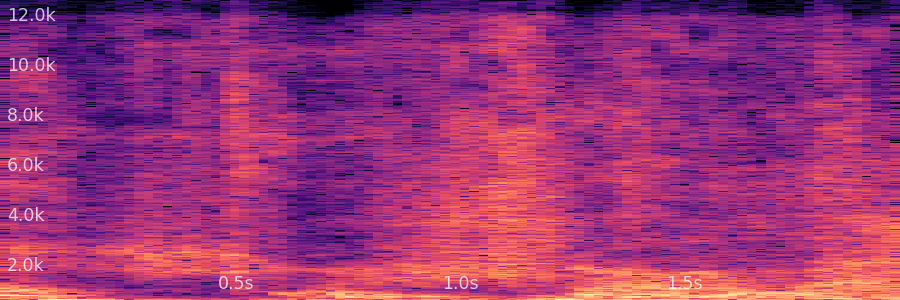
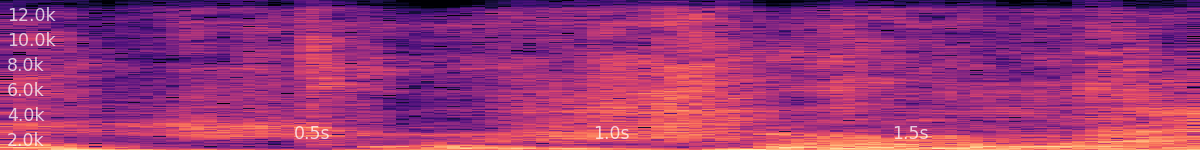

In [5]:
AudioSignal(generated_wave.cpu().numpy(), sample_rate=24000).widget()